<a href="https://colab.research.google.com/github/zeerau/deeptech_ready/blob/main/CNN_for_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

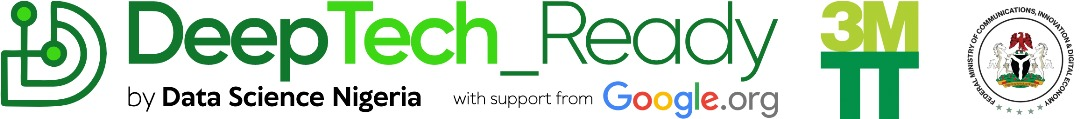

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\LATITUDE
[nltk_data]     7290\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [ ]:
dataset = pd.read_csv('IMDB Dataset.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Prepare Train Test Split

In [ ]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# Text Wrangling & Normalization

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

  2%|▏         | 681/35000 [00:00<00:20, 1708.85it/s]C:\Users\LATITUDE 7290\AppData\Local\Temp\ipykernel_30356\1676967255.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 15000/15000 [00:09<00:00, 1661.33it/s]

CPU times: total: 28.8 s
Wall time: 29.3 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175795), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175796
Number of Documents=35000


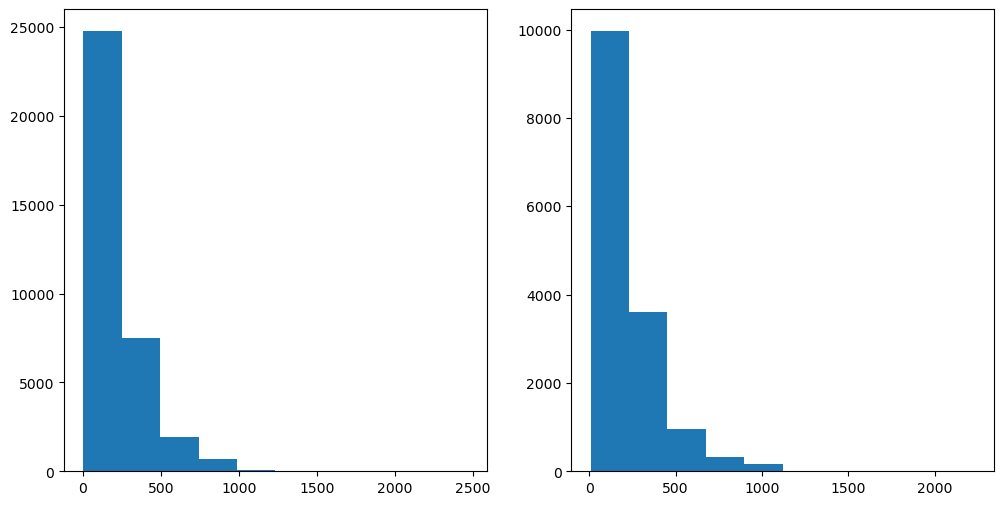

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [ ]:
EMBED_SIZE = 300
EPOCHS=5
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         52738800  
                                                                 
 conv1d_3 (Conv1D)           (None, 1000, 128)         153728    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 500, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 250, 32)          

## Model Training

In [ ]:
# Fit the model
model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/5
247/247 [==============================] - 597s 2s/step - loss: 0.3808 - accuracy: 0.8005 - val_loss: 0.2349 - val_accuracy: 0.9049
Epoch 2/5
247/247 [==============================] - 602s 2s/step - loss: 0.1136 - accuracy: 0.9607 - val_loss: 0.3004 - val_accuracy: 0.8851
Epoch 3/5
247/247 [==============================] - 600s 2s/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.4104 - val_accuracy: 0.8934
Epoch 4/5
247/247 [==============================] - 601s 2s/step - loss: 0.0117 - accuracy: 0.9958 - val_loss: 0.5693 - val_accuracy: 0.8803
Epoch 5/5
247/247 [==============================] - 604s 2s/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.7804 - val_accuracy: 0.8643


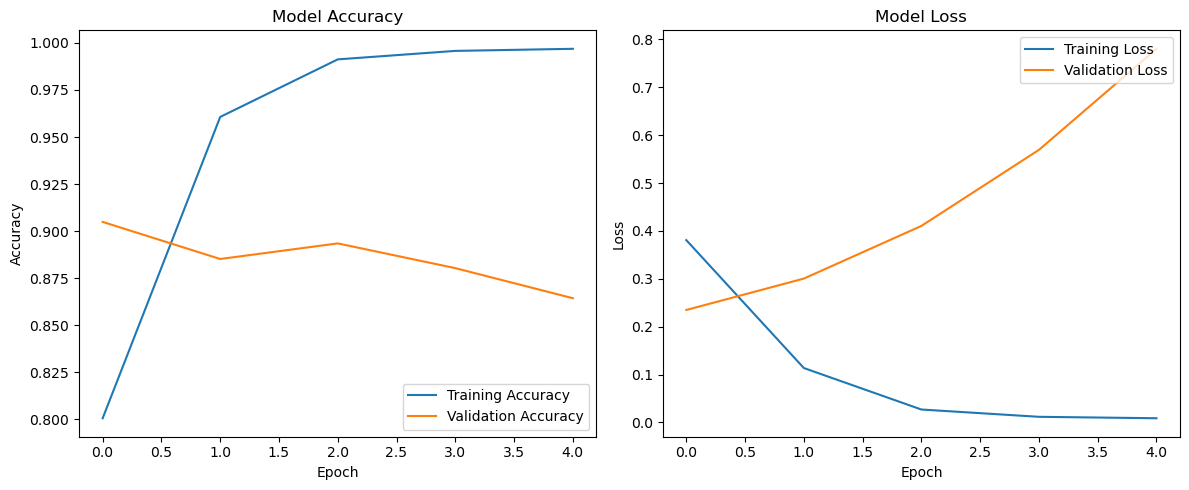

In [ ]:
# Assuming 'history' is the output of model.fit
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Model Evaluation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 66s 141ms/step - loss: 0.6867 - accuracy: 0.8797
Accuracy: 87.97%


In [ ]:
# Get predictions (probabilities) for each class
probabilities = model.predict(X_test)

# Convert probabilities to binary class predictions
predictions = (probabilities > 0.5).astype(int).ravel()

# Display the first 10 predictions
print(predictions[:10])


469/469 [==============================] - 68s 142ms/step
[0 1 0 1 1 0 1 1 1 1]


In [ ]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.94      0.81      0.87      7490
    positive       0.84      0.95      0.89      7510

    accuracy                           0.88     15000
   macro avg       0.89      0.88      0.88     15000
weighted avg       0.89      0.88      0.88     15000



,negative,positive
negative,6088,1402
positive,403,7107


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Ensure this is imported

# Function to preprocess a single raw text (uses existing utility functions)
def preprocess_single_text(text):
    # Use existing utility functions for preprocessing
    text = strip_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    text = text.lower()
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)  # Remove special characters
    text = re.sub(' +', ' ', text)  # Remove extra spaces
    text = text.strip()
    return text

# Function to predict sentiment for a raw text
def predict_sentiment(raw_text):
    # Preprocess the input text
    norm_text = preprocess_single_text(raw_text)

    # Convert to sequence using the tokenizer
    sequence = t.texts_to_sequences([norm_text])

    # Pad the sequence to the same length as the training data
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)  # Corrected this line

    # Predict sentiment probability
    probability = model.predict(padded_sequence)[0][0]

    # Convert probability to a class label
    sentiment = "positive" if probability > 0.5 else "negative"

    return sentiment, probability

# Example usage
new_text = "The plot was really messy and not interesting.. i regret watching the movie."
sentiment, probability = predict_sentiment(new_text)

print(f"Sentiment: {sentiment}")
print(f"Probability: {probability:.2f}")


1/1 [==============================] - 0s 34ms/step
Sentiment: negative
Probability: 0.11


**End**